## Adapted from Clustering_with_sentence_embeddings.ipynb from info 256 repo

This notebook explores the use of SentenceBERT to generate representations of sequences (sentences, documents) and clustering those representations using K-means.

In [1]:
# !pip install sentence-transformers

In [2]:
# Get movies summaries and book titles to cluster
# !wget https://raw.githubusercontent.com/dbamman/anlp23/main/data/plot_summaries.txt
# !wget https://raw.githubusercontent.com/dbamman/anlp23/main/data/loc/dev.tsv -O book_titles.txt

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score



from math import sqrt
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

In [4]:
stacked_ins_df = pd.read_csv('scraping/stacked_ins_df.csv')
# stacked_ins_df.head()

In [5]:
stacked_ins_df['owner_username'].unique()

array(['NYTimes', 'WSJ', 'Reuters'], dtype=object)

In [6]:
# stacked_ins_df_gaza = stacked_ins_df[stacked_ins_df['is_about_gaza_1'] == True]
# len(stacked_ins_df_gaza)

stacked_ins_df_gaza = stacked_ins_df

In [7]:
stacked_ins_df_gaza.tail()

,owner_username,url_code,time_utc,type,caption,likes,comments,is_about_gaza_1,is_about_gaza_2
186,Reuters,CzRKeiSLjZF,2023-11-05 14:45:16,GraphImage,Palestinians gather at the site of an Israeli ...,3326,504,True,True
187,Reuters,CzMXMF5xmf4,2023-11-03 18:00:05,GraphSidecar,Medics trapped in a clinic tending to the woun...,8241,2975,True,True
188,Reuters,CzL7SijL7rp,2023-11-03 13:56:20,GraphImage,Palestinians gather at the site of Israeli str...,3707,812,True,True
189,Reuters,CzHcfULLqwo,2023-11-01 20:10:15,GraphImage,Israeli soldiers from the IDF's Home Front Com...,5038,1275,True,True
190,Reuters,CzHIelUxZm8,2023-11-01 17:16:35,GraphVideo,📷 Photos of the month: The ongoing war between...,5458,628,True,True


In [8]:
stacked_ins_df_gaza.sort_values(by='time_utc')

,owner_username,url_code,time_utc,type,caption,likes,comments,is_about_gaza_1,is_about_gaza_2
102,WSJ,CyGa8b6NgB-,2023-10-07 14:06:13,GraphImage,Palestinian militants on Saturday launched the...,22263,1265,True,True
144,Reuters,CyGgKmlroTJ,2023-10-07 14:51:41,GraphImage,A man runs from fire after rockets were launch...,11025,989,True,True
76,NYTimes,CyGoENuOtKY,2023-10-07 16:00:43,GraphSidecar,Israel battled on Saturday to repel one of the...,93917,6596,True,True
75,NYTimes,CyGyJCRuj9E,2023-10-07 17:29:14,GraphVideo,"‘We Are at War,’ Netanyahu Says After Hamas At...",57571,4616,True,True
74,NYTimes,CyJSg52O2O1,2023-10-08 16:50:47,GraphVideo,More Than 900 Dead as Israel Warns of Long War...,88120,5165,True,True
...,...,...,...,...,...,...,...,...,...
147,NYTimes,CzoWW_yscYi,2023-11-14 14:51:58,GraphImage,More than 400 political appointees and staff m...,94775,4313,True,True
176,Reuters,CzpATJQrVQj,2023-11-14 20:58:05,GraphImage,Tens of thousands of demonstrators gathered in...,8078,2208,True,True
146,NYTimes,CzpMGzRP0l4,2023-11-14 22:43:02,GraphVideo,Families of Hostages Held by Hamas Begin March...,42347,4793,True,True
145,NYTimes,Czq8ES4LZAX,2023-11-15 14:59:33,GraphImage,The Israeli military forged ahead with its rai...,10336,2545,True,True


In [9]:
stacked_news_df = pd.read_csv('scraping/stacked_news_df.csv')
stacked_news_df.tail()

,datetime,url,title,owner_username
3957,2023-10-17 15:48:00,/article/idUSKBN31G1YT,Trump pledges to expel immigrants who support ...,Reuters
3958,2023-10-17 15:42:00,/article/idUSKBN31H1ZZ,UN warns Gaza civilians being 'packed in ever-...,Reuters
3959,2023-10-17 15:41:00,/article/idUSKBN31H24T,German chancellor meets families in Israel of ...,Reuters
3960,2023-10-17 15:37:00,/article/idUSC6N3AX041,CORRECTED-Jordan 'strongly condemns' Israeli a...,Reuters
3961,2023-10-17 15:28:00,/article/idUSS8N3AW01V,Palestinians clash with Abbas' forces in West ...,Reuters


In [10]:
stacked_news_df.sort_values(by='datetime')

,datetime,url,title,owner_username
1003,2023-10-07 00:00:00,/live/2023/10/07/world/israel-gaza-attack/bide...,Biden and other U.S. leaders condemn the Hamas...,NYTimes
988,2023-10-07 00:00:00,/2023/10/07/world/some-israelis-are-flying-hom...,Some Israelis are flying home to fight.,NYTimes
989,2023-10-07 00:00:00,/2023/10/07/world/middleeast/israel-netanyahu-...,"‘We Are at War,’ Netanyahu Says After Hamas At...",NYTimes
990,2023-10-07 00:00:00,/2023/10/07/world/middleeast/israel-gaza-confl...,Here is a timeline of the clashes between Pale...,NYTimes
991,2023-10-07 00:00:00,/live/2023/10/07/world/israel-gaza-attack/rene...,Renewed Palestinian rocket fire strikes centra...,NYTimes
...,...,...,...,...
1895,2023-11-15 22:46:00,/article/idUSL1N3CH094,"US, China, Southeast Asia defence officials me...",Reuters
1894,2023-11-15 22:50:00,/article/idUSKBN32B07M,"US, China, Southeast Asia defence officials me...",Reuters
1892,2023-11-15 23:01:00,/article/idUSKBN32B05E,US Capitol police clash with protesters demand...,Reuters
1893,2023-11-15 23:01:00,/article/idUSL1N3CH06N,UPDATE 1-US Capitol police clash with proteste...,Reuters


In [11]:
stacked_news_df['owner_username'].unique()

array(['WSJ', 'NYTimes', 'Reuters'], dtype=object)

In [12]:
len(stacked_news_df)

3962

In [13]:
sentence_model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')

In [14]:
def cosine(one, two):
    return np.dot(one,two)/(sqrt(np.dot(one,one)) * sqrt(np.dot(two,two)))

In [15]:
# def run_all(df, data, model, num_clusters=10):

#     X=[]

#     # Get sentence embeddings for each doc
    
#     for doc in data:
#         embedding=model.encode(doc)
#         X.append(embedding)

#     X=np.array(X)

#     # Run K-means
#     kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)

#     # For each cluster, print out the n documents closest to the cluster center
#     clusters={}
#     for idx, label in enumerate(kmeans.labels_):
#         if label not in clusters:
#             clusters[label]=[]
#         clusters[label].append((idx, data[idx][1]))

#     for label in clusters:
#         sims={}
#         cluster_center=kmeans.cluster_centers_[label]
#         for idx, doc in clusters[label]:
#             sim=cosine(cluster_center, X[idx])
#             sims[idx]=sim
#         for k, v in sorted(sims.items(), key=lambda item: item[1], reverse=True)[:10]:
#             # print(k,"%.3f" % v, data[k][1])
#             if len(data[k].split()) < 20:
#                 print(df.loc[k]['owner_username'], k,"%.3f" % v, data[k])
#             else:
#                 print(df.loc[k]['owner_username'], k,"%.3f" % v, data[k][:200]+'...')

#         print()


In [16]:
def run_all(list_username, data, model, num_clusters=10):

    X=[]

    # Get sentence embeddings for each doc
    
    for doc in data:
        embedding=model.encode(doc)
        X.append(embedding)

    X=np.array(X)

    # Run K-means
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)

    # For each cluster, print out the n documents closest to the cluster center
    clusters={}
    for idx, label in enumerate(kmeans.labels_):
        if label not in clusters:
            clusters[label]=[]
        clusters[label].append((idx, data[idx][1]))

    for label in clusters:
        
        media_count = []
        
        sims={}
        cluster_center=kmeans.cluster_centers_[label]
        for idx, doc in clusters[label]:
            sim=cosine(cluster_center, X[idx])
            sims[idx]=sim
            
        print('top 5 for this cluster')
        for k, v in sorted(sims.items(), key=lambda item: item[1], reverse=True)[:5]:
            print(list_username[k], k,"%.3f" % v, data[k])
            media_count.append(list_username[k])
            
        print('bottom 5 for this cluster')
        for k, v in sorted(sims.items(), key=lambda item: item[1], reverse=True)[-5:]:
            print(list_username[k], k,"%.3f" % v, data[k])
            media_count.append(list_username[k])
    
        print('Media count list for this cluster is:')
        print(np.unique(np.array(media_count), return_counts=True))

        print('------- new clusters ------')


In [17]:
def run_all_complete(list_username, data, model, num_clusters=10):

    X=[]

    # Get sentence embeddings for each doc
    
    for doc in data:
        embedding=model.encode(doc)
        X.append(embedding)

    X=np.array(X)

    # Run K-means
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)

    # For each cluster, print out the n documents closest to the cluster center
    clusters={}
    for idx, label in enumerate(kmeans.labels_):
        if label not in clusters:
            clusters[label]=[]
        clusters[label].append((idx, data[idx][1]))

    for label in clusters:
        
        media_count = []
        
        sims={}
        cluster_center=kmeans.cluster_centers_[label]
        for idx, doc in clusters[label]:
            sim=cosine(cluster_center, X[idx])
            sims[idx]=sim
            
#         print('top 5 for this cluster')
        for k, v in sorted(sims.items(), key=lambda item: item[1], reverse=True):
            # print(list_username[k], k,"%.3f" % v, data[k])
            media_count.append(list_username[k])
    
        print('Media count list for this cluster is:')
        print(np.unique(np.array(media_count), return_counts=True))

        print('------- new clusters ------')


In [18]:
import pandas as pd

# Example DataFrame
data = {
    'A': [1, 2, 3],
    'B': [4, 5, 6],
    'C': [7, 8, 9]
}

df = pd.DataFrame(data)

# Creating a new DataFrame with only column names and no rows
columns_only_df = pd.DataFrame(columns=df.columns)
columns_only_df


,A,B,C


In [19]:
def run_all_dfs(ins_or_news_df, data, model, num_clusters=10):

    X=[]
    
    if len(ins_or_news_df.columns) == 9:
        target = 'ins'
    else:
        target = 'news'

    # Get sentence embeddings for each doc
    
    for doc in data:
        embedding=model.encode(doc)
        X.append(embedding)

    X=np.array(X)

    # Run K-means
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)

    # For each cluster, print out the n documents closest to the cluster center
    clusters={}
    for idx, label in enumerate(kmeans.labels_):
        if label not in clusters:
            clusters[label]=[]
        clusters[label].append((idx, data[idx][1]))
    
    
    df = pd.DataFrame(columns=(list(ins_or_news_df.columns) + ['cluster_id', 'cosine_score']))
    
    for label in clusters:
        
        cluster_id = target + '_' + str(int(label))
        
        media_count = []
        
        sims={}
        cluster_center=kmeans.cluster_centers_[label]
        for idx, doc in clusters[label]:
            sim=cosine(cluster_center, X[idx])
            sims[idx]=sim
        
        add_df = ins_or_news_df.loc[sims.keys()]
        add_df['cluster_id'] = cluster_id
        add_df['cosine_score'] = sims.values()
        
        df = pd.concat([df, add_df], ignore_index=True)
    
    return df


In [20]:
run_all_dfs(stacked_news_df, list(stacked_news_df['title']), sentence_model, num_clusters=23)

C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,datetime,url,title,owner_username,cluster_id,cosine_score
0,2023-11-15 22:34:00,https://www.wsj.com/world/middle-east/israel-h...,Israel Says It Found Evidence of Hamas Activit...,WSJ,news_10,0.817253
1,2023-11-15 17:20:00,https://www.wsj.com/world/middle-east/u-s-reli...,U.S. Relied on Intercepts in Assessing Hamas’s...,WSJ,news_10,0.788720
2,2023-11-15 14:03:00,https://www.wsj.com/world/middle-east/u-s-pres...,U.S. Presses for Hamas to Release Hostages as ...,WSJ,news_10,0.845201
3,2023-11-12 00:04:00,https://www.wsj.com/world/middle-east/hamas-ne...,Hamas Needed a New Way to Get Money From Iran....,WSJ,news_10,0.575903
4,2023-11-10 20:44:00,https://www.wsj.com/world/middle-east/israel-r...,Israel Races to Root Out Hamas as Calls for Ga...,WSJ,news_10,0.794722
...,...,...,...,...,...,...
3957,2023-10-26 00:00:00,/2023/10/26/briefing/gaza-israel-house-speaker...,Thursday Briefing,NYTimes,news_14,0.965684
3958,2023-10-25 00:00:00,/2023/10/25/briefing/israel-gaza-house-speaker...,Wednesday Briefing,NYTimes,news_14,0.960250
3959,2023-10-24 00:00:00,/2023/10/24/briefing/gaza-israel-germany-polit...,Tuesday Briefing,NYTimes,news_14,0.968628
3960,2023-10-23 00:00:00,/2023/10/23/briefing/israel-gaza-ukraine.html?...,Monday Briefing,NYTimes,news_14,0.973560


# News Article Titles

In [21]:
stacked_news_df[stacked_news_df['owner_username'] == 'NYTimes']

,datetime,url,title,owner_username
421,2023-10-19 00:00:00,/live/2023/10/19/world/israel-hamas-war-gaza-n...,Biden will argue that U.S. national security i...,NYTimes
422,2023-10-19 00:00:00,/live/2023/10/20/world/israel-hamas-war-gaza-n...,A Hamas leader says not all of the Israeli hos...,NYTimes
423,2023-10-19 00:00:00,/live/2023/10/19/world/israel-hamas-war-gaza-n...,"At a hospital in southern Gaza, a backup gener...",NYTimes
424,2023-10-19 00:00:00,/2023/10/19/world/middleeast/israel-visa-trave...,Biden Moves Up Program Allowing Israelis to Tr...,NYTimes
425,2023-10-19 00:00:00,/2023/10/19/briefing/un-aid-gaza-jim-jordan-sp...,The U.N. Brokered a Deal to Bring Aid Into Gaza,NYTimes
...,...,...,...,...
1886,2023-10-20 00:00:00,/2023/10/20/briefing/biden-speech-gaza-russia-...,Friday Briefing,NYTimes
1887,2023-10-20 00:00:00,/2023/10/20/pageoneplus/corrections-oct-20-202...,"Corrections: Oct. 20, 2023",NYTimes
1888,2023-10-20 00:00:00,/2023/10/19/opinion/biden-speech-israel-gaza.h...,Israel Is About to Make a Terrible Mistake,NYTimes
1889,2023-10-20 00:00:00,/video/us/politics/100000009141800/biden-israe...,President Biden Reaffirms Support for Israel a...,NYTimes


In [22]:
stacked_news_df[stacked_news_df['owner_username'] == 'Reuters']

,datetime,url,title,owner_username
1891,2023-11-15 23:17:00,/article/idUSL1N3CG192,"UPDATE 11-Biden, Xi's 'blunt' talks yield deal...",Reuters
1892,2023-11-15 23:01:00,/article/idUSKBN32B05E,US Capitol police clash with protesters demand...,Reuters
1893,2023-11-15 23:01:00,/article/idUSL1N3CH06N,UPDATE 1-US Capitol police clash with proteste...,Reuters
1894,2023-11-15 22:50:00,/article/idUSKBN32B07M,"US, China, Southeast Asia defence officials me...",Reuters
1895,2023-11-15 22:46:00,/article/idUSL1N3CH094,"US, China, Southeast Asia defence officials me...",Reuters
...,...,...,...,...
3957,2023-10-17 15:48:00,/article/idUSKBN31G1YT,Trump pledges to expel immigrants who support ...,Reuters
3958,2023-10-17 15:42:00,/article/idUSKBN31H1ZZ,UN warns Gaza civilians being 'packed in ever-...,Reuters
3959,2023-10-17 15:41:00,/article/idUSKBN31H24T,German chancellor meets families in Israel of ...,Reuters
3960,2023-10-17 15:37:00,/article/idUSC6N3AX041,CORRECTED-Jordan 'strongly condemns' Israeli a...,Reuters


In [23]:
stacked_news_df[stacked_news_df['owner_username'] == 'WSJ']

,datetime,url,title,owner_username
0,2023-11-15 22:34:00,https://www.wsj.com/world/middle-east/israel-h...,Israel Says It Found Evidence of Hamas Activit...,WSJ
1,2023-11-15 18:36:00,https://www.wsj.com/articles/u-s-executive-bra...,Opinion: Joe Biden Faces a Deep State Revolt,WSJ
2,2023-11-15 18:11:00,https://www.wsj.com/articles/the-first-humanit...,Opinion: Gaza Is the First Humanitarian-Crisis...,WSJ
3,2023-11-15 18:09:00,https://www.wsj.com/articles/my-gazan-friend-i...,Opinion: My Gazan Friend Is Dead,WSJ
4,2023-11-15 17:39:00,https://www.wsj.com/articles/all-is-quiet-in-o...,Opinion: All Is Quiet in Oil Markets—for Now,WSJ
...,...,...,...,...
416,2023-10-08 12:20:00,https://www.wsj.com/articles/israel-faces-its-...,Opinion: Israel Faces Its 9/11,WSJ
417,2023-10-08 02:04:00,https://www.wsj.com/world/middle-east/barrage-...,Israel Declares War on Hamas After Surprise As...,WSJ
418,2023-10-07 20:23:00,https://www.wsj.com/articles/israel-gaza-hamas...,Opinion: War Returns to the Middle East,WSJ
419,2023-10-07 20:14:00,https://www.wsj.com/world/middle-east/after-at...,"After Attack, Israel Wrestles With Question: H...",WSJ


In [24]:
stacked_news_df['title']

0       Israel Says It Found Evidence of Hamas Activit...
1            Opinion: Joe Biden Faces a Deep State Revolt
2       Opinion: Gaza Is the First Humanitarian-Crisis...
3                        Opinion: My Gazan Friend Is Dead
4            Opinion: All Is Quiet in Oil Markets—for Now
                              ...                        
3957    Trump pledges to expel immigrants who support ...
3958    UN warns Gaza civilians being 'packed in ever-...
3959    German chancellor meets families in Israel of ...
3960    CORRECTED-Jordan 'strongly condemns' Israeli a...
3961    Palestinians clash with Abbas' forces in West ...
Name: title, Length: 3962, dtype: object

In [25]:
X=[]

# Get sentence embeddings for each doc

for doc in list(stacked_news_df['title']):
    embedding=sentence_model.encode(doc)
    X.append(embedding)

X=np.array(X)

X

array([[-0.0082622 , -0.0218971 ,  0.04896918, ...,  0.02009523,
        -0.00625773,  0.04286475],
       [-0.01144459, -0.05182511, -0.00647752, ..., -0.03318299,
         0.00297466,  0.01761231],
       [-0.00366927,  0.02909034,  0.02242508, ...,  0.0764574 ,
        -0.06286895,  0.06034866],
       ...,
       [ 0.00482755, -0.01378335,  0.02089608, ...,  0.04851355,
        -0.03244081,  0.03765354],
       [-0.01186595,  0.03589661,  0.01869767, ...,  0.00637806,
        -0.06252066, -0.01046395],
       [ 0.0227901 ,  0.03788514,  0.0151611 , ..., -0.00436618,
        -0.00978318,  0.04245645]], dtype=float32)

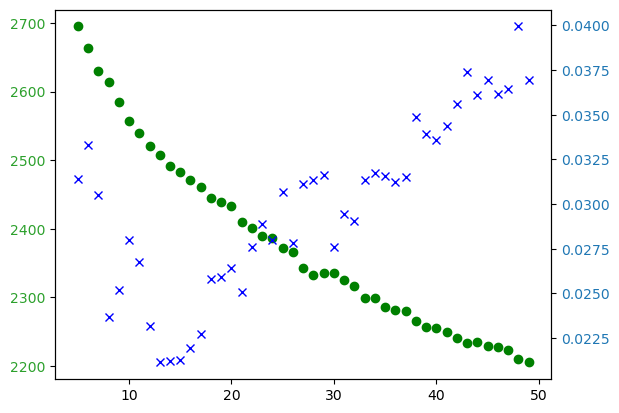

In [26]:
range_n_clusters = list(range(5,50))
silho_score_list = []
distorsions = []

for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10).fit(X)
    cluster_labels = clusterer.predict(X)
    
    distorsions.append(clusterer.inertia_)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    silho_score_list.append(silhouette_avg)
#     print(
#         "For n_clusters =",
#         n_clusters,
#         "The average silhouette_score is :",
#         silhouette_avg,
#     )

fig, ax1 = plt.subplots()
ax1.plot(range_n_clusters, distorsions, 'go')
ax1.tick_params(axis='y', labelcolor='tab:green')

# fig2 = plt.figure()
ax2 = ax1.twinx()
ax2.plot(range_n_clusters, silho_score_list, 'bx')
ax2.tick_params(axis='y', labelcolor='tab:blue')

In [27]:
range_n_clusters[:20], silho_score_list[:20]

([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
 [0.03139277,
  0.033307265,
  0.030516708,
  0.023671184,
  0.025185518,
  0.028009398,
  0.02676829,
  0.023155963,
  0.021138906,
  0.02119446,
  0.021259518,
  0.021928808,
  0.022732267,
  0.0258159,
  0.025899608,
  0.02641148,
  0.025056822,
  0.027604783,
  0.02890076,
  0.027964523])

In [ ]:
run_all(list(stacked_news_df['owner_username']), list(stacked_news_df['title']), sentence_model, num_clusters=23)

C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [29]:
run_all_complete(list(stacked_news_df['owner_username']), list(stacked_news_df['title']), sentence_model, num_clusters=23)

C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Media count list for this cluster is:
(array(['NYTimes', 'Reuters', 'WSJ'], dtype='<U7'), array([137,  94,  76], dtype=int64))
------- new clusters ------
Media count list for this cluster is:
(array(['NYTimes', 'Reuters', 'WSJ'], dtype='<U7'), array([73, 15, 18], dtype=int64))
------- new clusters ------
Media count list for this cluster is:
(array(['NYTimes', 'Reuters', 'WSJ'], dtype='<U7'), array([180,  66,  42], dtype=int64))
------- new clusters ------
Media count list for this cluster is:
(array(['NYTimes', 'Reuters', 'WSJ'], dtype='<U7'), array([115,  56,  12], dtype=int64))
------- new clusters ------
Media count list for this cluster is:
(array(['NYTimes', 'Reuters', 'WSJ'], dtype='<U7'), array([ 7, 71,  5], dtype=int64))
------- new clusters ------
Media count list for this cluster is:
(array(['NYTimes', 'Reuters', 'WSJ'], dtype='<U7'), array([ 44, 119,  26], dtype=int64))
------- new clusters ------
Media count list for this cluster is:
(array(['NYTimes', 'Reuters', 'WSJ'], 

In [30]:
clustered_news_df = run_all_dfs(stacked_news_df, list(stacked_news_df['title']), sentence_model, num_clusters=23)
clustered_news_df

C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,datetime,url,title,owner_username,cluster_id,cosine_score
0,2023-11-15 22:34:00,https://www.wsj.com/world/middle-east/israel-h...,Israel Says It Found Evidence of Hamas Activit...,WSJ,news_10,0.817253
1,2023-11-15 17:20:00,https://www.wsj.com/world/middle-east/u-s-reli...,U.S. Relied on Intercepts in Assessing Hamas’s...,WSJ,news_10,0.788720
2,2023-11-15 14:03:00,https://www.wsj.com/world/middle-east/u-s-pres...,U.S. Presses for Hamas to Release Hostages as ...,WSJ,news_10,0.845201
3,2023-11-12 00:04:00,https://www.wsj.com/world/middle-east/hamas-ne...,Hamas Needed a New Way to Get Money From Iran....,WSJ,news_10,0.575903
4,2023-11-10 20:44:00,https://www.wsj.com/world/middle-east/israel-r...,Israel Races to Root Out Hamas as Calls for Ga...,WSJ,news_10,0.794722
...,...,...,...,...,...,...
3957,2023-10-26 00:00:00,/2023/10/26/briefing/gaza-israel-house-speaker...,Thursday Briefing,NYTimes,news_14,0.965684
3958,2023-10-25 00:00:00,/2023/10/25/briefing/israel-gaza-house-speaker...,Wednesday Briefing,NYTimes,news_14,0.960250
3959,2023-10-24 00:00:00,/2023/10/24/briefing/gaza-israel-germany-polit...,Tuesday Briefing,NYTimes,news_14,0.968629
3960,2023-10-23 00:00:00,/2023/10/23/briefing/israel-gaza-ukraine.html?...,Monday Briefing,NYTimes,news_14,0.973560


In [31]:
clustered_news_df['cluster_id'].unique()

array(['news_10', 'news_18', 'news_21', 'news_1', 'news_16', 'news_8',
       'news_3', 'news_13', 'news_15', 'news_0', 'news_19', 'news_2',
       'news_17', 'news_12', 'news_4', 'news_9', 'news_5', 'news_7',
       'news_6', 'news_22', 'news_20', 'news_11', 'news_14'], dtype=object)

In [32]:
list(clustered_news_df[clustered_news_df['cluster_id'] == 'news_1']['title'])

['Opinion: My Gazan Friend Is Dead',
 'A Foreign Student Saved His Friends From Hamas. Then He Vanished.',
 'Opinion: The Scenes of Genocide I Saw in Israeli Morgues',
 'China and Russia Claim Moral High Ground Over Palestinian Deaths',
 'Palestinian Death Statistics Remain a Subject of Controversy',
 'Israeli Military Shows Footage From Oct. 7 Attacks, Some Taken From Militants’ Body Cams',
 'Released American Hostages Face a Long Road to Healing, Father Says',
 'American Grandmother Stuck in Gaza After Visit to Ailing Father',
 'Bereaved Israelis Emerge From Mourning Into an Uncertain World',
 'In Israel, Tradition Requires 10 to Attend a Funeral. Hundreds Came.',
 'U.S. Families With Loved Ones Missing in Israel Turn to Washington for Help',
 'Opinion: Massacre at the Israel Music Festival',
 'An Israeli family buries and mourns its dead.',
 'An American stuck in Gaza hoped to flee. Then an airstrike hit.',
 'Photos: Life Under the Bombs in Khan Younis',
 'A Gaza doctor loses his wi

In [33]:
count = 0
for c_id in clustered_news_df['cluster_id'].unique():
    print('group', count, '-', c_id)
    print(clustered_news_df[clustered_news_df['cluster_id'] == c_id]['title'])
    count += 1

group 0 - news_10
0      Israel Says It Found Evidence of Hamas Activit...
1      U.S. Relied on Intercepts in Assessing Hamas’s...
2      U.S. Presses for Hamas to Release Hostages as ...
3      Hamas Needed a New Way to Get Money From Iran....
4      Israel Races to Root Out Hamas as Calls for Ga...
                             ...                        
302    UPDATE 1-US lawmakers urge White House crack d...
303    Disinformation surge threatens to fuel Israel-...
304    Israel must decide how long anti-Hamas operati...
305        SNAPSHOT-Israel and Hamas at war: Latest news
306    Trump pledges to expel immigrants who support ...
Name: title, Length: 307, dtype: object
group 1 - news_18
307         Opinion: Joe Biden Faces a Deep State Revolt
308    David Cameron Makes Surprise Return to U.K. Go...
309            Opinion: Obama’s Lesson for Rashida Tlaib
310    Democrats Grow More Confident in Campaign Mess...
311    Opinion: Notable & Quotable: Glenn Kessler, Jo...
            

In [34]:
clustered_news_df.to_csv('clustered_news_df.csv', index=False)

In [47]:
clustered_news_df.groupby(by='cluster_id')

In [35]:
pd.DataFrame(np.array([[0.09659863946, 0.06054421769, 0.1544217687, 0.06530612245, 0.009523809524, 0.03401360544, 0.0693877551, 0.05850340136], [0.1701149425, 0.1609195402, 0.2459770115, 0.1954022989, 0.1264367816, 0.3149425287, 0.1517241379, 0.4459770115], [0.03814582327, 0.01207146306, 0.02221149203, 0.007242877837, 0.004828585225, 0.009657170449, 0.01545147272, 0.007725736359]]),
             columns=['Hamas in General', 'Biden', 'Gaza in General', 'Safety', 'Global Economy', 'Global Politics', 'Ethnical Conflicts', 'Gaza Hospital'])

,Hamas in General,Biden,Gaza in General,Safety,Global Economy,Global Politics,Ethnical Conflicts,Gaza Hospital
0,0.096599,0.060544,0.154422,0.065306,0.009524,0.034014,0.069388,0.058503
1,0.170115,0.160920,0.245977,0.195402,0.126437,0.314943,0.151724,0.445977
2,0.038146,0.012071,0.022211,0.007243,0.004829,0.009657,0.015451,0.007726


In [36]:
import pandas as pd

# Given data
data = {
    'Hamas in General': [0.09659863946, 0.1701149425, 0.03814582327],
    'Biden': [0.06054421769, 0.1609195402, 0.01207146306],
    'Gaza in General': [0.1544217687, 0.2459770115, 0.02221149203],
    'Safety': [0.06530612245, 0.1954022989, 0.007242877837],
    'Global Economy': [0.009523809524, 0.1264367816, 0.004828585225],
    'Global Politics': [0.03401360544, 0.3149425287, 0.009657170449],
    'Ethnical Conflicts': [0.0693877551, 0.1517241379, 0.01545147272],
    'Gaza Hospital': [0.05850340136, 0.4459770115, 0.007725736359]
}

# Creating the DataFrame
df_news_top8 = pd.DataFrame(data)

# Set the index to 'NYT', 'Reuters', 'WSJ'
df_news_top8.index = ['NYT', 'Reuters', 'WSJ']

df_news_top8


,Hamas in General,Biden,Gaza in General,Safety,Global Economy,Global Politics,Ethnical Conflicts,Gaza Hospital
NYT,0.096599,0.060544,0.154422,0.065306,0.009524,0.034014,0.069388,0.058503
Reuters,0.170115,0.160920,0.245977,0.195402,0.126437,0.314943,0.151724,0.445977
WSJ,0.038146,0.012071,0.022211,0.007243,0.004829,0.009657,0.015451,0.007726


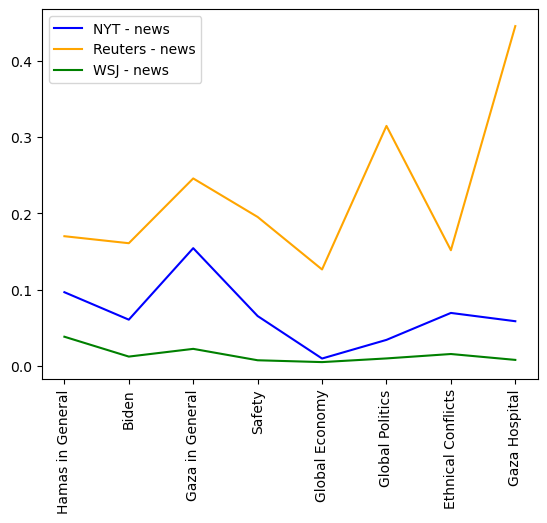

In [37]:
for index, row in df_news_top8.iterrows():
    if index == "NYT":
        color = 'blue'
    elif index == "WSJ":
        color = 'green'
    elif index == "Reuters":
        color = 'orange'
    label = index + ' - news'
    plt.plot(row.values, color=color, label=label)
plt.xticks(np.arange(0, 8, step=1))
plt.xticks(np.arange(0, 8, step=1), df_news_top8.columns, rotation=90)
plt.legend()

# Instagram Post Captions

In [38]:
X=[]

# Get sentence embeddings for each doc

for doc in list(stacked_ins_df_gaza['caption']):
    embedding=sentence_model.encode(doc)
    X.append(embedding)

X=np.array(X)

X

array([[-0.00307452,  0.01535686,  0.03079531, ...,  0.01719161,
        -0.04966913, -0.01669358],
       [-0.00062978, -0.04388437,  0.01460525, ..., -0.01043237,
        -0.04854497,  0.01292623],
       [ 0.0048606 , -0.05569305,  0.00834523, ..., -0.04577689,
         0.01679458,  0.06866963],
       ...,
       [-0.00293341, -0.01734316,  0.03204017, ...,  0.04217303,
        -0.00566243,  0.04164176],
       [ 0.01459708, -0.01156629,  0.06301074, ...,  0.05865731,
        -0.01188882,  0.05750514],
       [ 0.0379788 , -0.03302502, -0.00876169, ...,  0.02723553,
        -0.00584167,  0.06518394]], dtype=float32)

C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans 

C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans 

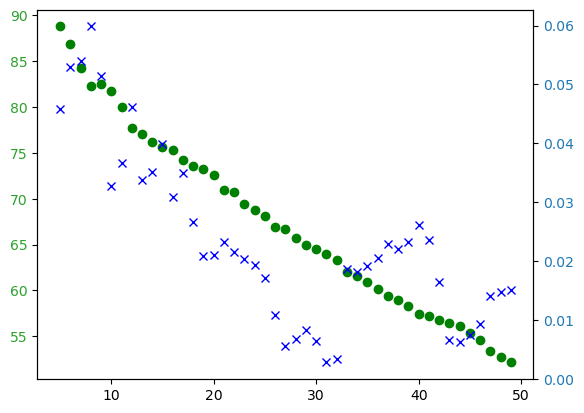

In [39]:
range_n_clusters = list(range(5,50))
silho_score_list = []
distorsions = []

for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10).fit(X)
    cluster_labels = clusterer.predict(X)
    
    distorsions.append(clusterer.inertia_)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    silho_score_list.append(silhouette_avg)
#     print(
#         "For n_clusters =",
#         n_clusters,
#         "The average silhouette_score is :",
#         silhouette_avg,
#     )

fig, ax1 = plt.subplots()
ax1.plot(range_n_clusters, distorsions, 'go')
ax1.tick_params(axis='y', labelcolor='tab:green')

# fig2 = plt.figure()
ax2 = ax1.twinx()
ax2.plot(range_n_clusters, silho_score_list, 'bx')
ax2.tick_params(axis='y', labelcolor='tab:blue')

In [40]:
range_n_clusters[:20], silho_score_list[:20]

([5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
 [0.04585105,
  0.053044103,
  0.053976145,
  0.05984474,
  0.05139349,
  0.032812987,
  0.03665007,
  0.046178497,
  0.033722594,
  0.035193678,
  0.039858975,
  0.030949514,
  0.03495503,
  0.026700782,
  0.020867324,
  0.020999812,
  0.023200022,
  0.021535566,
  0.02032692,
  0.019379266])

In [41]:
run_all(list(stacked_ins_df_gaza['owner_username']), list(stacked_ins_df_gaza['caption']), sentence_model, num_clusters=15)

C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


top 5 for this cluster
Reuters 134 0.905 Misinformation has spread online in the wake of Hamas’ Oct. 7 surprise attack on Israel. Reuters examines one of the false videos.
 
Public broadcaster Kan said the Israeli death toll had risen to more than 1,300. Most were civilians gunned down in their homes, on the streets or at a dance party. Scores of Israeli and foreign hostages were taken back to Gaza.
 
Israel has responded so far by putting Gaza, home to 2.3 million people, under total siege and launching by far the most powerful bombing campaign in the 75-year-old history of the Israeli-Palestinian conflict, destroying whole neighbourhoods. Gaza authorities said more than 1,400 Palestinians have been killed and more than 6,000 have been wounded.
🔗 Read more about the Israel-Hamas war at our link in bio.
 
#Reuters #video #videonews #topstories #topnews #Israel #Israelis #Hamas #Palestinians #Palestinianterritories #Palestinian #Hamasattack #conflict #Gaza #IsraelHamas #IsraelHamaswar #

In [42]:
run_all_complete(list(stacked_ins_df_gaza['owner_username']), list(stacked_ins_df_gaza['caption']), sentence_model, num_clusters=15)

C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Media count list for this cluster is:
(array(['NYTimes', 'Reuters', 'WSJ'], dtype='<U7'), array([16, 11, 11], dtype=int64))
------- new clusters ------
Media count list for this cluster is:
(array(['NYTimes', 'WSJ'], dtype='<U7'), array([11,  3], dtype=int64))
------- new clusters ------
Media count list for this cluster is:
(array(['NYTimes', 'Reuters', 'WSJ'], dtype='<U7'), array([6, 2, 3], dtype=int64))
------- new clusters ------
Media count list for this cluster is:
(array(['NYTimes', 'Reuters', 'WSJ'], dtype='<U7'), array([18,  5,  3], dtype=int64))
------- new clusters ------
Media count list for this cluster is:
(array(['NYTimes', 'Reuters', 'WSJ'], dtype='<U7'), array([9, 2, 4], dtype=int64))
------- new clusters ------
Media count list for this cluster is:
(array(['NYTimes', 'Reuters'], dtype='<U7'), array([6, 2], dtype=int64))
------- new clusters ------
Media count list for this cluster is:
(array(['NYTimes', 'Reuters', 'WSJ'], dtype='<U7'), array([3, 2, 3], dtype=int64))
-

In [43]:
clustered_ins_df = run_all_dfs(stacked_ins_df_gaza, list(stacked_ins_df_gaza['caption']), sentence_model, num_clusters=15)
clustered_ins_df

C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\linzh\anaconda3\envs\anlp\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,owner_username,url_code,time_utc,type,caption,likes,comments,is_about_gaza_1,is_about_gaza_2,cluster_id,cosine_score
0,NYTimes,CzFGEBgP0-G,2023-10-31 22:20:32,GraphVideo,Deadly Israeli Airstrike Hits Dense Area in No...,38247,7422,True,True,ins_9,0.796953
1,NYTimes,Cy_ax2KucUe,2023-10-29 17:21:20,GraphSidecar,The Israeli military on Sunday signaled a heav...,96099,7018,True,True,ins_9,0.780283
2,NYTimes,Cy9Ff4Ruznc,2023-10-28 19:36:54,GraphImage,Prime Minister Benjamin Netanyahu of Israel sa...,15768,3528,True,True,ins_9,0.805388
3,NYTimes,CyyZ4jTLJOd,2023-10-24 16:05:16,GraphVideo,Death Toll Climbs in Gaza as Israel Intensifie...,28395,5652,True,True,ins_9,0.763368
4,NYTimes,CyyCx34Npv7,2023-10-24 12:42:28,GraphImage,More Palestinians have been killed in the Isra...,41508,3548,True,True,ins_9,0.732164
...,...,...,...,...,...,...,...,...,...,...,...
186,Reuters,CzpATJQrVQj,2023-11-14 20:58:05,GraphImage,Tens of thousands of demonstrators gathered in...,8078,2208,True,True,ins_12,0.828894
187,NYTimes,CyjnjJDPqdQ,2023-10-18 22:14:11,GraphSidecar,The U.S.’s relationship with Israel burst to t...,35375,3131,True,True,ins_13,0.838862
188,NYTimes,Czahn1EOq1j,2023-11-09 06:02:05,GraphVideo,Third GOP Debate: Haley and DeSantis Take Lead...,8987,2412,True,True,ins_13,0.838862
189,NYTimes,CyN331NL5_M,2023-10-10 11:36:13,GraphVideo,Videos posted on social media and closed-circu...,137860,8300,True,True,ins_11,0.852338


In [44]:
clustered_ins_df.to_csv('clustered_ins_df.csv', index=False)

In [45]:
stacked_ins_df_gaza

,owner_username,url_code,time_utc,type,caption,likes,comments,is_about_gaza_1,is_about_gaza_2
0,NYTimes,CzFGEBgP0-G,2023-10-31 22:20:32,GraphVideo,Deadly Israeli Airstrike Hits Dense Area in No...,38247,7422,True,True
1,NYTimes,CzEqpU4Ohz1,2023-10-31 18:22:13,GraphVideo,"For weeks, Tasneem Ismael Ahel, a 19-year-old ...",12249,2482,True,True
2,NYTimes,CzEf7vLuyt2,2023-10-31 16:57:32,GraphVideo,"Antony Blinken, the U.S. secretary of state, a...",96244,6451,True,True
3,NYTimes,CzCmCdtv4uI,2023-10-30 22:59:15,GraphVideo,Israeli Mother Is Brought to Tears at Abductio...,33442,7233,True,True
4,NYTimes,CzCCjyNL6-Q,2023-10-30 17:49:15,GraphVideo,War Through the Eyes of Gaza’s Children\n\n“I ...,101485,6303,True,True
...,...,...,...,...,...,...,...,...,...
186,Reuters,CzRKeiSLjZF,2023-11-05 14:45:16,GraphImage,Palestinians gather at the site of an Israeli ...,3326,504,True,True
187,Reuters,CzMXMF5xmf4,2023-11-03 18:00:05,GraphSidecar,Medics trapped in a clinic tending to the woun...,8241,2975,True,True
188,Reuters,CzL7SijL7rp,2023-11-03 13:56:20,GraphImage,Palestinians gather at the site of Israeli str...,3707,812,True,True
189,Reuters,CzHcfULLqwo,2023-11-01 20:10:15,GraphImage,Israeli soldiers from the IDF's Home Front Com...,5038,1275,True,True
